In [1]:
!python -m pip install --upgrade pip
!pip3 uninstall numpy -y
!pip3 uninstall matplotlib -y
!pip3 install d2l
!pip3 install --upgrade numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: numpy 1.22.4
Uninstalling numpy-1.22.4:
  Successfully uninstalled numpy-1.22.4
Found existing installation: matplotlib 3.7.1
Uninstalling matplotlib-3.7.1:
  Successfully uninstalled matplotlib-3.7.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 95.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 110.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.24.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.15.1 requires pandas>=1.3.0, but you have pandas 1.2.4 which is incompatible.
d2l 0.17.6 requires numpy==1.21.5, but you have numpy 1.24.3 which is incompatible.
mizani 0.8.1 requires pandas>=1.3.5, but you have pandas 1.2.4 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
plotnine 0.10.1 requires pandas>=1.3.5, but you have pandas 1.2.4 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.2

In [42]:
%matplotlib inline
import collections
import inspect
from IPython import display
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import hashlib
import os
import tarfile
import zipfile
import requests

d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

In [43]:
def download(url, folder='../data', sha1_hash=None):
    """Download a file to folder and return the local filepath."""
    if not url.startswith('http'):
        # For back compatability
        url, sha1_hash = d2l.DATA_HUB[url]
    os.makedirs(folder, exist_ok=True)
    fname = os.path.join(folder, url.split('/')[-1])
    # Check if hit cache
    if os.path.exists(fname) and sha1_hash:
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    # Download
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def extract(filename, folder=None):
    """Extract a zip/tar file into folder."""
    base_dir = os.path.dirname(filename)
    _, ext = os.path.splitext(filename)
    assert ext in ('.zip', '.tar', '.gz'), 'Only support zip/tar files.'
    if ext == '.zip':
        fp = zipfile.ZipFile(filename, 'r')
    else:
        fp = tarfile.open(filename, 'r')
    if folder is None:
        folder = base_dir
    fp.extractall(folder)

In [44]:
def add_to_class(Class):
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

In [45]:
class HyperParameters:
    def save_hyperparameters(self, ignore=[]):
        raise NotImplemented

In [46]:
class ProgressBoard(HyperParameters):
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

In [47]:
@add_to_class(HyperParameters)
def save_hyperparameters(self, ignore=[]):
    """Save function arguments into class attributes."""
    frame = inspect.currentframe().f_back
    _, _, _, local_vars = inspect.getargvalues(frame)
    self.hparams = {k:v for k, v in local_vars.items()
                    if k not in set(ignore+['self']) and not k.startswith('_')}
    for k, v in self.hparams.items():
        setattr(self, k, v)

In [48]:
@add_to_class(ProgressBoard)
def draw(self, x, y, label, every_n=1):
    Point = collections.namedtuple('Point', ['x', 'y'])
    if not hasattr(self, 'raw_points'):
        self.raw_points = collections.OrderedDict()
        self.data = collections.OrderedDict()
    if label not in self.raw_points:
        self.raw_points[label] = []
        self.data[label] = []
    points = self.raw_points[label]
    line = self.data[label]
    points.append(Point(x, y))
    if len(points) != every_n:
        return
    mean = lambda x: sum(x) / len(x)
    line.append(Point(mean([p.x for p in points]),
                      mean([p.y for p in points])))
    points.clear()
    if not self.display:
        return
    d2l.use_svg_display()
    if self.fig is None:
        self.fig = d2l.plt.figure(figsize=self.figsize)
    plt_lines, labels = [], []
    for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
        plt_lines.append(d2l.plt.plot([p.x for p in v], [p.y for p in v],
                                      linestyle=ls, color=color)[0])
        labels.append(k)
    axes = self.axes if self.axes else d2l.plt.gca()
    if self.xlim: axes.set_xlim(self.xlim)
    if self.ylim: axes.set_ylim(self.ylim)
    if not self.xlabel: self.xlabel = self.x
    axes.set_xlabel(self.xlabel)
    axes.set_ylabel(self.ylabel)
    axes.set_xscale(self.xscale)
    axes.set_yscale(self.yscale)
    axes.legend(plt_lines, labels)
    display.display(self.fig)
    display.clear_output(wait=True)

In [49]:
class Module(nn.Module, HyperParameters):
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

In [84]:
class DataModule(HyperParameters):
    def __init__(self, root='../data', num_workers=4, **kwargs):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        """Defined in :numref:`sec_synthetic-regression-data`"""
        tensors = tuple(a[indices] for a in tensors)
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(dataset, self.batch_size,
                                           shuffle=train)

In [119]:
class Trainer(HyperParameters):
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                if self.gradient_clip_val > 0:  # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1

    def prepare_batch(self, batch):
        return batch

In [120]:
class Classifier(Module):
    """The base class of classification models."""
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

In [121]:
@add_to_class(Module)
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), lr=self.lr)

In [122]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X, *args):
        raise NotImplementedError

In [123]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

    def init_state(self, enc_all_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [124]:
class EncoderDecoder(Classifier):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        return self.decoder(dec_X, dec_state)[0]

In [125]:
def init_seq2seq(module):
    """Initialize weights for Seq2Seq."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

class Seq2SeqEncoder(Encoder):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        embs = self.embedding(X.t().type(torch.int64))
        outputs, state = self.rnn(embs)
        return outputs, state

In [126]:
class Seq2SeqDecoder(Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens,
                           num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        context = enc_output[-1]
        context = context.repeat(embs.shape[0], 1, 1)
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        return outputs, [enc_output, hidden_state]

In [127]:
class Seq2Seq(EncoderDecoder):
    """The RNN encoder-decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [128]:
class MTFraEng(DataModule):
    """The English-French dataset."""
    def _download(self):
        extract(download(
            d2l.DATA_URL+'fra-eng.zip', self.root,
            '94646ad1522d915e7b0f9296181140edcf86a4f5'))
        with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
            return f.read()

In [129]:
@add_to_class(MTFraEng)
def _preprocess(self, text):
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text.lower())]
    return ''.join(out)

In [130]:
@add_to_class(MTFraEng)
def _tokenize(self, text, max_examples=None):
    src, tgt = [], []
    for i, line in enumerate(text.split('\n')):
        if max_examples and i > max_examples: break
        parts = line.split('\t')
        if len(parts) == 2:
            src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
            tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
    return src, tgt

In [131]:
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """Plot the histogram for list length pairs."""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

In [132]:
@add_to_class(MTFraEng)
def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128):
    super(MTFraEng, self).__init__()
    self.save_hyperparameters()
    self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(
        self._download())

@add_to_class(MTFraEng)
def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
    def _build_array(sentences, vocab, is_tgt=False):
        pad_or_trim = lambda seq, t: (
            seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
        sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
        if is_tgt:
            sentences = [['<bos>'] + s for s in sentences]
        if vocab is None:
            vocab = d2l.Vocab(sentences, min_freq=2)
        array = torch.tensor([vocab[s] for s in sentences])
        valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
        return array, vocab, valid_len
    src, tgt = self._tokenize(self._preprocess(raw_text),
                              self.num_train + self.num_val)
    src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
    tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
    return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]),
            src_vocab, tgt_vocab)

In [133]:
@add_to_class(MTFraEng)
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader(self.arrays, train, idx)

In [134]:
@add_to_class(MTFraEng)
def build(self, src_sentences, tgt_sentences):
    raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(
        src_sentences, tgt_sentences)])
    arrays, _, _ = self._build_arrays(
        raw_text, self.src_vocab, self.tgt_vocab)
    return arrays

## **11.1. Queries, Keys, and Values**

지금까지 다뤘던 모델들은 input size가 정의되어 있다. 즉 input size가 정해져 있다는 것이다.

하지만 input 토큰을 순차적으로 처리한다는 발상에서 가변 길이의 input size를 처리할 수 있다. 하지만 이런 방법은 input의 길이가 길어지면 모든 토큰을 잘 다룰 수 없게 된다.

데이터베이스는 Key와 Value 쌍의 집합이라 볼 수 있고, 이 쌍에 대해 동작하는 Query를 작성할 수 있다. 데이터베이스의 contents에 따라서 Query는 다른 결과를 도출할 것이다. 이를 포함하여 데이터베이스의 특성으로는

- We can design queries q that operate on (k,v) pairs in such a manner as to be valid regardless of the database size.

- The same query can receive different answers, according to the contents of the database.

- The “code” being executed to operate on a large state space (the database) can be quite simple (e.g., exact match, approximate match, top-k).

- There is no need to compress or simplify the database to make the operations effective.

로 정리할 수 있다...고 한다. 이 아이디어에서 출발하여, Attention이라는 것을

$\mathrm{Attention}(\mathbf{q}, \mathcal{D}) \stackrel{\mathrm{def}}{=} \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i$

와 같이 정의할 수 있다. $\mathcal{D}$는 데이터베이스를 뜻하고, $\alpha$는 kernel로, query의 key에 대한 가중치이다. 가중치는 다양한 형태로 정의할 수 있다. 예를 들어 모든 가중치가 0 이상이거나, 모든 가중치가 같은 값을 가지거나, 또는 convex combination (모든 원소는 0 이상, 모두 더하면 1)의 형태로 정의할 수 있다. 보통은 softmax를 취하여 convex combination의 형태로 많이 쓴다고 한다.

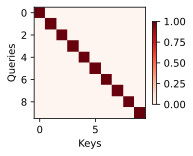

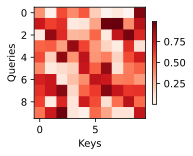

In [135]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    d2l.use_svg_display()
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

attention_weights = torch.rand(100).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

간단한 Visualization 코드이다. torch.eye는 크로네커 델타를 생성해준다. 

## **11.2. Attention Pooling by Similarity**

$\begin{split}\begin{aligned}
\alpha(\mathbf{q}, \mathbf{k}) & = \exp\left(-\frac{1}{2} \|\mathbf{q} - \mathbf{k}\|^2 \right) && \mathrm{Gaussian} \\
\alpha(\mathbf{q}, \mathbf{k}) & = 1 \text{ if } \|\mathbf{q} - \mathbf{k}\| \leq 1 && \mathrm{Boxcar} \\
\alpha(\mathbf{q}, \mathbf{k}) & = \mathop{\mathrm{max}}\left(0, 1 - \|\mathbf{q} - \mathbf{k}\|\right) && \mathrm{Epanechikov}
\end{aligned}\end{split}$

query와 key 간의 가중치(kernel)를 위와 같이 정의할 수 있다. 이 장에서는 이 Kernel Attention을 가지고 Regression에 적용해 본다.

$f(\mathbf{q}) = \sum_i \mathbf{v}_i \frac{\alpha(\mathbf{q}, \mathbf{k}_i)}{\sum_j \alpha(\mathbf{q}, \mathbf{k}_j)}$

(x, y)를 x를 Key에, y를 Value에 대응시킬 수 있다. Query $q$는 Key에 대한 정답을 가리킨다.

아래 코드는 다음 함수에 대해 Attention Kernel을 이용하여 Nadayara-Watson Kernel Regression을 진행하는 코드이다.

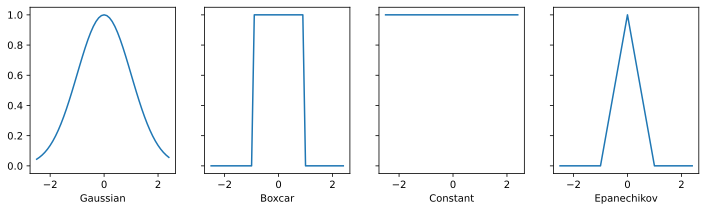

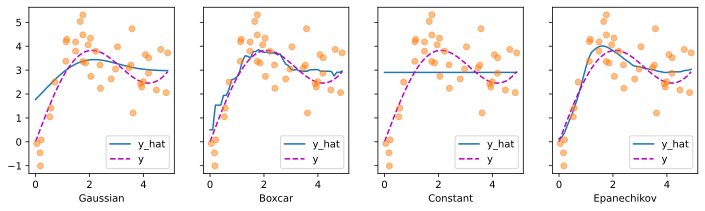

In [136]:
import numpy as np
from torch import nn
from torch.nn import functional as F

d2l.use_svg_display()

fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

def gaussian(x):
    return torch.exp(-x**2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

def f(x):
    return 2 * torch.sin(x) + x

n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    k = kernel(dists).type(torch.float32)
    attention_w = k / k.sum(0)
    y_hat = y_train@attention_w
    return y_hat, attention_w

def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

plot(x_train, y_train, x_val, y_val, kernels, names)

새로 알게 된 점 : ML 입문할 때 TF 프레임워크로 했었는데, Torch에서는 @가 행렬곱을 표현한다는 것을 알게 되었다.

Nadaraya_watson 함수는 위의 Regression 식을 그대로 표현한 것이다. x_train이 query가 되고, kernel을 통해 Query에 대한 가중치와 y_train 간의 행렬곱으로 Attention Value를 산출한다.

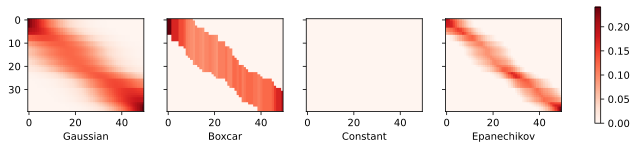

In [137]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

#### 11.2.3. Adapting Attention Pooling

$\alpha(\mathbf{q}, \mathbf{k}) = \exp\left(-\frac{1}{2 \sigma^2} \|\mathbf{q} - \mathbf{k}\|^2 \right)$

위 식을 통해 Attention의 범위를 조정할 수 있다.

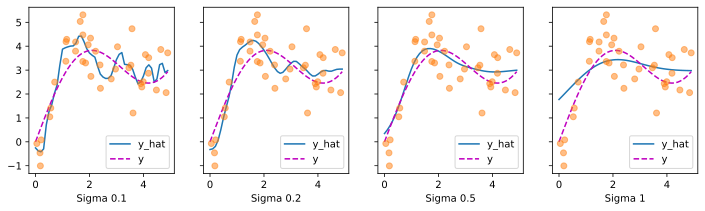

In [138]:
sigmas = (0.1, 0.2, 0.5, 1)
names = ['Sigma ' + str(sigma) for sigma in sigmas]

def gaussian_with_width(sigma):
    return (lambda x: torch.exp(-x**2 / (2*sigma**2)))

kernels = [gaussian_with_width(sigma) for sigma in sigmas]
plot(x_train, y_train, x_val, y_val, kernels, names)

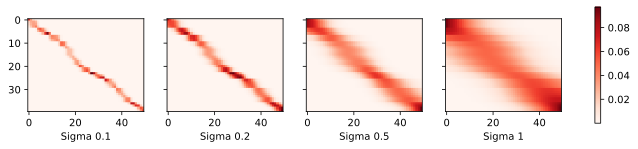

In [139]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

sigma가 작으면 kernel을 통한 가중치가 커지게 되고, 그만큼 Regression이 요동치게 된다. sigma가 클 수록 Regression이 부드러워 진다.

##**11.3.Attention Scoring Functions**

여태까지의 Kernel을 보면 Distance-Based이다. 이는 dot product보다 비싼 연산이다. 이를 대체하기 위해 Attention Scoring Function을 도입한다...라고 한다.

$\begin{split}\begin{aligned}
a(\mathbf{q}, \mathbf{k}_i) & = -\frac{1}{2} \|\mathbf{q} - \mathbf{k}_i\|^2  \\
& = \mathbf{q}^\top \mathbf{k}_i -\frac{1}{2} \|\mathbf{k}_i\|^2  -\frac{1}{2} \|\mathbf{q}\|^2
\end{aligned}\end{split}$

위 식을 통해 Distance를 구할 때 dot product를 포함하는 것을 볼 수 있다. 

추가로, 세 번째 항은 Kernel의 Normalization 과정에서 소거되고(exponential 연산이기 때문에), $||{k}_{i}||$ 항도 batch normalization을 하면 같은 이유로 소거되기 때문에 결국에는 dot product 항만 남는다.

query와 key를 평균 0, 분산 1인 ${d}$차원의 균등분포라고 가정할 때, 둘의 dot product는 평균 0, 분산 ${d}$가 된다. 따라서 밑의 식처럼 Scaling을 진행한다.

$a(\mathbf{q}, \mathbf{k}_i) = \mathbf{q}^\top \mathbf{k}_i / \sqrt{d}$

마지막으로 kernel에 대해 Normalization을 해주면 dot product 기반의 kernel이 완성된다.

$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(\mathbf{q}^\top \mathbf{k}_i / \sqrt{d})}{\sum_{j=1} \exp(\mathbf{q}^\top \mathbf{k}_j / \sqrt{d})}$

In [140]:
import math

#### 11.3.2. Convenience Functions

##### 11.3.2.1. Masked Softmax Operation

In [141]:
def masked_softmax(X, valid_lens):
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

input에 padding을 추가하는 softmax이다.

##### 11.3.2.2. Batch Matrix Multiplication

DL 프레임워크는 위와 같이 Batch로 묶어서 행렬곱이 가능하다.

#### 11.3.3. Scaled Dot-Product Attention

Softmax와 Kernel을 조합하여 Attention을 다음과 같이 정의할 수 있다.

$\mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}$

추가로, 위 식은 Batch Matrix Multiplication을 수반한다.

In [142]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()

DotProductAttention(
  (dropout): Dropout(p=0.5, inplace=False)
)

In [143]:
#d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  #xlabel='Keys', ylabel='Queries')

위 코드에서 forward할 때 attention_weights를 저장하는데 왜 안될까...

#### 11.3.4. Additive Attention

만약 query와 k의 차원이 다르다면, 이를 중개하는 행렬을 사용하거나, 또는 Additive Attention이라는 것을 쓰면 된다. 

$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$

$\mathbf W_q\in\mathbb R^{h\times q} \mathbf, W_k\in\mathbb R^{h\times k}, \mathbf w_v\in\mathbb R^{h}$

In [144]:
class AdditiveAttention(nn.Module):
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [145]:
#d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  #xlabel='Keys', ylabel='Queries')

이로써 가변 길이의 input variable에 대해 Attention Scoring을 구현한다.

## **11.4. The Bahdanau Attention Mechanism**

In [146]:
class AttentionDecoder(d2l.Decoder):
    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        raise NotImplementedError

In [147]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.attention = AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_lens = state
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

Bahdanau Attention Mechanism은 바로 전 Token과 현재 토큰에 대해 Additive Attention Scoring을 진행한다. RNN 위에 Attention Mechanism을 올려놓은 모습이다.

## **11.5. Multi-Head Attention**

Query에 대해 그냥 Attention 1개가 아니라 여러 개를 적용하여 이어 붙이는 메커니즘이다.

$\mathbf{h}_i = f(\mathbf W_i^{(q)}\mathbf q, \mathbf W_i^{(k)}\mathbf k,\mathbf W_i^{(v)}\mathbf v) \in \mathbb R^{p_v}$

이렇게 정의하면 다양한 길이로 Attention을 적용할 수 있다.

In [150]:
class MultiHeadAttention(Module):
    """Multi-head attention."""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        output = self.attention(queries, keys, values, valid_lens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)

In [151]:
@add_to_class(MultiHeadAttention)
def transpose_qkv(self, X):
    """Transposition for parallel computation of multiple attention heads."""
    X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
    X = X.permute(0, 2, 1, 3)
    return X.reshape(-1, X.shape[2], X.shape[3])

@add_to_class(MultiHeadAttention)
def transpose_output(self, X):
    """Reverse the operation of transpose_qkv."""
    X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [152]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, num_kvpairs = 2, 4, 6
valid_lens = torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## **11.6. Self Attention and positional Encoding**

#### 11.6.1. Self-Attention

$\mathbf{y}_i = f(\mathbf{x}_i, (\mathbf{x}_1, \mathbf{x}_1), \ldots, (\mathbf{x}_n, \mathbf{x}_n)) \in \mathbb{R}^d$



In [156]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))

#### 11.6.3. Positional Encoding

Self-Attention은 input sequence의 순서를 보존하지 않기 때문에, 추가적인 input을 넣어 Positional Encoding을 수행한다.

In [158]:
class PositionalEncoding(nn.Module):
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

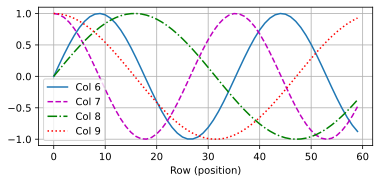

In [159]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

이것이 Relative Positional Information, 이걸로 이진법을 표현하는건가?

##### 11.6.3.1. Absolute Positional Information

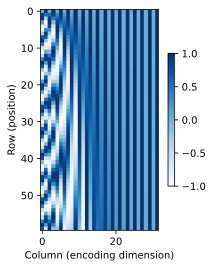

In [161]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

90도 돌려서 보면 로그함수??

## **11.7. The Transformer Architecture**

Transformer는 Attention Mechanism을 기반으로 하여 Token을 순차적으로 처리하는 메커니즘이다.

#### 11.7.2. Positionwise Feed-Forward Networks

In [164]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

음... MLP와 아직까지 크게 다른 건 없어 보인다.

In [165]:
ffn = PositionWiseFFN(4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[ 0.4346,  0.1258,  0.5094, -0.6120, -0.4031,  0.1363, -0.3210, -0.0344],
        [ 0.4346,  0.1258,  0.5094, -0.6120, -0.4031,  0.1363, -0.3210, -0.0344],
        [ 0.4346,  0.1258,  0.5094, -0.6120, -0.4031,  0.1363, -0.3210, -0.0344]],
       grad_fn=<SelectBackward0>)

차원 하나가 어디갔지???

#### 11.7.3. Residual Connection and Layer Normalization

In [166]:
ln = nn.LayerNorm(2)
bn = nn.LazyBatchNorm1d()
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# Compute mean and variance from X in the training mode
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [167]:
class AddNorm(nn.Module):
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

원래 Input 값을 Output에 Concat시켜준다. -> Residual Connection

#### 11.7.4. Encoder

D2L에 나와있는 모델에 따라서 Encoder 모델을 구축한다.

In [169]:
class TransformerEncoderBlock(nn.Module):
    """The Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [170]:
class TransformerEncoder(Encoder):
    """The Transformer encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

#### 11.7.5. Decoder

In [171]:
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the Transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [172]:
class TransformerDecoder(AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

## **11.8. Transformers For Vision**

이 절에서는 원래 seq2seq을 위해 고안된 Transformer를 Image에 적용한다. 이미지를 분할하여 Positional Embedding을 거친 뒤 Transformer에 적용하는 방식이다.

In [175]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=96, patch_size=16, num_hiddens=512):
        super().__init__()
        def _make_tuple(x):
            if not isinstance(x, (list, tuple)):
                return (x, x)
            return x
        img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
        self.num_patches = (img_size[0] // patch_size[0]) * (
            img_size[1] // patch_size[1])
        self.conv = nn.LazyConv2d(num_hiddens, kernel_size=patch_size,
                                  stride=patch_size)

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        return self.conv(X).flatten(2).transpose(1, 2)

In [176]:
class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5):
        super().__init__()
        self.dense1 = nn.LazyLinear(mlp_num_hiddens)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.LazyLinear(mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout2(self.dense2(self.dropout1(self.gelu(
            self.dense1(x)))))

In [177]:
class ViTBlock(nn.Module):
    def __init__(self, num_hiddens, norm_shape, mlp_num_hiddens,
                 num_heads, dropout, use_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(norm_shape)
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.ln2 = nn.LayerNorm(norm_shape)
        self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout)

    def forward(self, X, valid_lens=None):
        X = X + self.attention(*([self.ln1(X)] * 3), valid_lens)
        return X + self.mlp(self.ln2(X))

In [178]:
class ViT(Classifier):
    """Vision Transformer."""
    def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens,
                 num_heads, num_blks, emb_dropout, blk_dropout, lr=0.1,
                 use_bias=False, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.patch_embedding = PatchEmbedding(
            img_size, patch_size, num_hiddens)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        num_steps = self.patch_embedding.num_patches + 1  # Add the cls token
        # Positional embeddings are learnable
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_steps, num_hiddens))
        self.dropout = nn.Dropout(emb_dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", ViTBlock(
                num_hiddens, num_hiddens, mlp_num_hiddens,
                num_heads, blk_dropout, use_bias))
        self.head = nn.Sequential(nn.LayerNorm(num_hiddens),
                                  nn.Linear(num_hiddens, num_classes))

    def forward(self, X):
        X = self.patch_embedding(X)
        X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), 1)
        X = self.dropout(X + self.pos_embedding)
        for blk in self.blks:
            X = blk(X)
        return self.head(X[:, 0])